In [2]:
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.optimizers import *
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator


from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/Emotion Detector

/content/drive/MyDrive/Emotion Detector


In [ ]:
train_dir = 'train/'
val_dir = 'test/'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [9]:
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

In [ ]:
# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

print(model.summary())

opt = Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 128)      

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001, decay=1e-6),metrics=['accuracy'])
model_info = model.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=15,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

Epoch 1/15
  5/448 [..............................] - ETA: 4:11:48 - loss: 2.4140 - accuracy: 0.1719

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

In [ ]:
model.save_weights('epochs_15_emotion_model.h5')

In [27]:
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("emotion_model.h5", by_name = True, skip_mismatch = True)

In [6]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [30]:
from google.colab.patches import cv2_imshow

def photo(frame):
  # bounding_box = cv2.CascadeClassifier('drive/MyDrive/Emotion Detector/emoji_creator/data/haarcascade_frontalface_default.xml')
  bounding_box = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  cv2_imshow(gray_frame)
  num_faces = bounding_box.detectMultiScale(gray_frame,scaleFactor=1.3, minNeighbors=5)
  for (x, y, w, h) in num_faces:
      cv2.rectangle(frame, (x, y), (x+w, y+h+10), (255, 0, 0), 2)
      roi_gray_frame = gray_frame[y:y + h, x:x + w]
      cropped_img = cv2.resize(roi_gray_frame, (200, 200))
      cv2_imshow(cropped_img)
      cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (200, 200)), -1), 0)
      emotion_prediction = loaded_model.predict(cropped_img)
      maxindex = int(np.argmax(emotion_prediction))
      cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
      print(emotion_dict[maxindex])

<IPython.core.display.Javascript object>

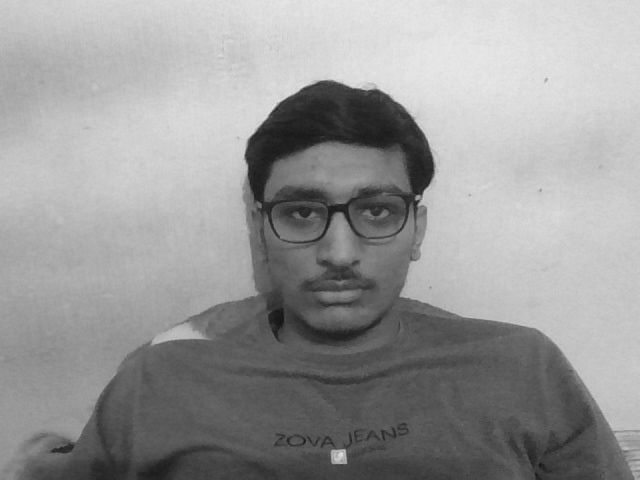

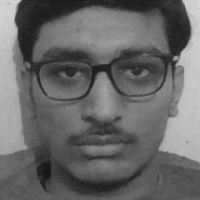

Sad


In [10]:
from IPython.display import Image
import cv2
from google.colab.patches import cv2_imshow

try:
  filename = take_photo()
  # print('Saved to {}'.format(filename))
  img = cv2.imread('photo.jpg', cv2.IMREAD_UNCHANGED)
  photo(img)
  # Show the image which was just taken.
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

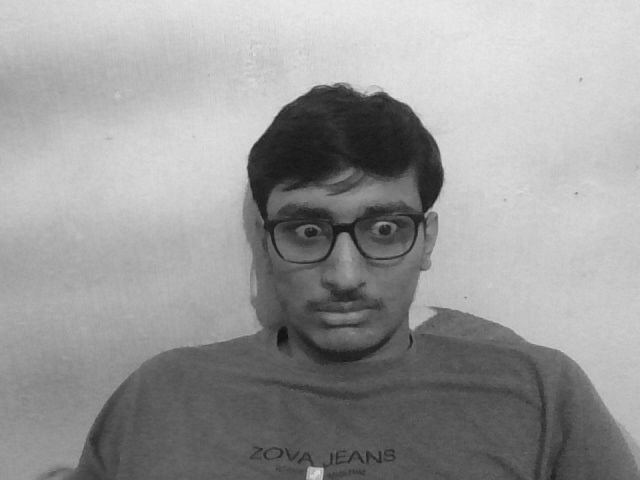

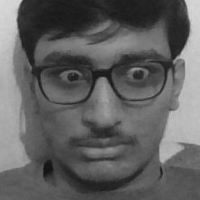

[[3.2255286e-01 1.6538691e-04 6.6831541e-01 5.4042012e-04 6.0902996e-04
  3.5511481e-03 4.2658201e-03]]
Fearful


In [24]:
from IPython.display import Image
import cv2
from google.colab.patches import cv2_imshow

try:
  filename = take_photo()
  # print('Saved to {}'.format(filename))
  img = cv2.imread('photo.jpg', cv2.IMREAD_UNCHANGED)
  photo(img)
  # Show the image which was just taken.
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

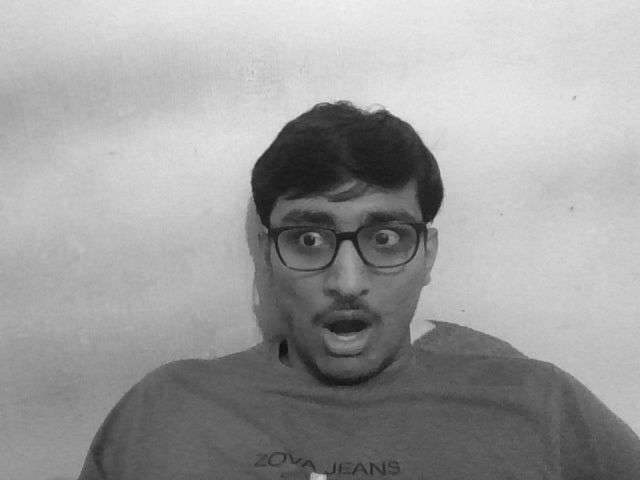

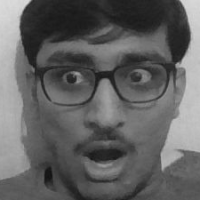

[[4.4264725e-01 1.7326081e-04 5.4184306e-01 5.3530338e-04 4.7496273e-04
  6.5896311e-03 7.7365055e-03]]
Fearful


In [25]:
from IPython.display import Image
import cv2
from google.colab.patches import cv2_imshow

try:
  filename = take_photo()
  # print('Saved to {}'.format(filename))
  img = cv2.imread('photo.jpg', cv2.IMREAD_UNCHANGED)
  photo(img)
  # Show the image which was just taken.
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))